In [1]:
import os, sys, json
from camera_calibration.No_Bells_Just_Whistles.inference import process_image_sequence
from camera_calibration.No_Bells_Just_Whistles.sn_calibration.src.camera import Camera
import numpy as np
from camera_calibration.filters import (  # type: ignore
    linear_interpolation,
    to_valid_cam_params,
    camParamsPerImage_to_camParamsPerType,
    camParamsPerType_to_camParamsPerImage,
    outliers_remover,
    camParamsSmoothing,
    smoothing_using_banner_corners,
)
from semantic_segmentation.filter import keep_biggest_blob
from tqdm import tqdm
import cv2
from compositing.utils import compute_banner_model_params, composite_logo_into_video
from copy import deepcopy
from matplotlib import pyplot as plt

In [2]:
# imgPath = 'video/Images/360/'
imgPath = 'work_dir/images/'
maskPath = 'work_dir/masks/'
nFrames = 750
nWorkers = 14
imgWidth = 1920
imgHeight = 1080

NBJW inference to compute the camera parameters

In [3]:
# process_image_sequence(imgPath, ".", nFrames, weights_kp="./camera_calibration/No_Bells_Just_Whistles/SV_kp", weights_line="./camera_calibration/No_Bells_Just_Whistles/SV_lines")

Camera parameters basic filtering

750
camParamsPerType keys:  dict_keys(['pan_degrees', 'tilt_degrees', 'roll_degrees', 'position_meters', 'x_focal_length', 'y_focal_length', 'principal_point', 'radial_distortion', 'tangential_distortion', 'thin_prism_distortion'])


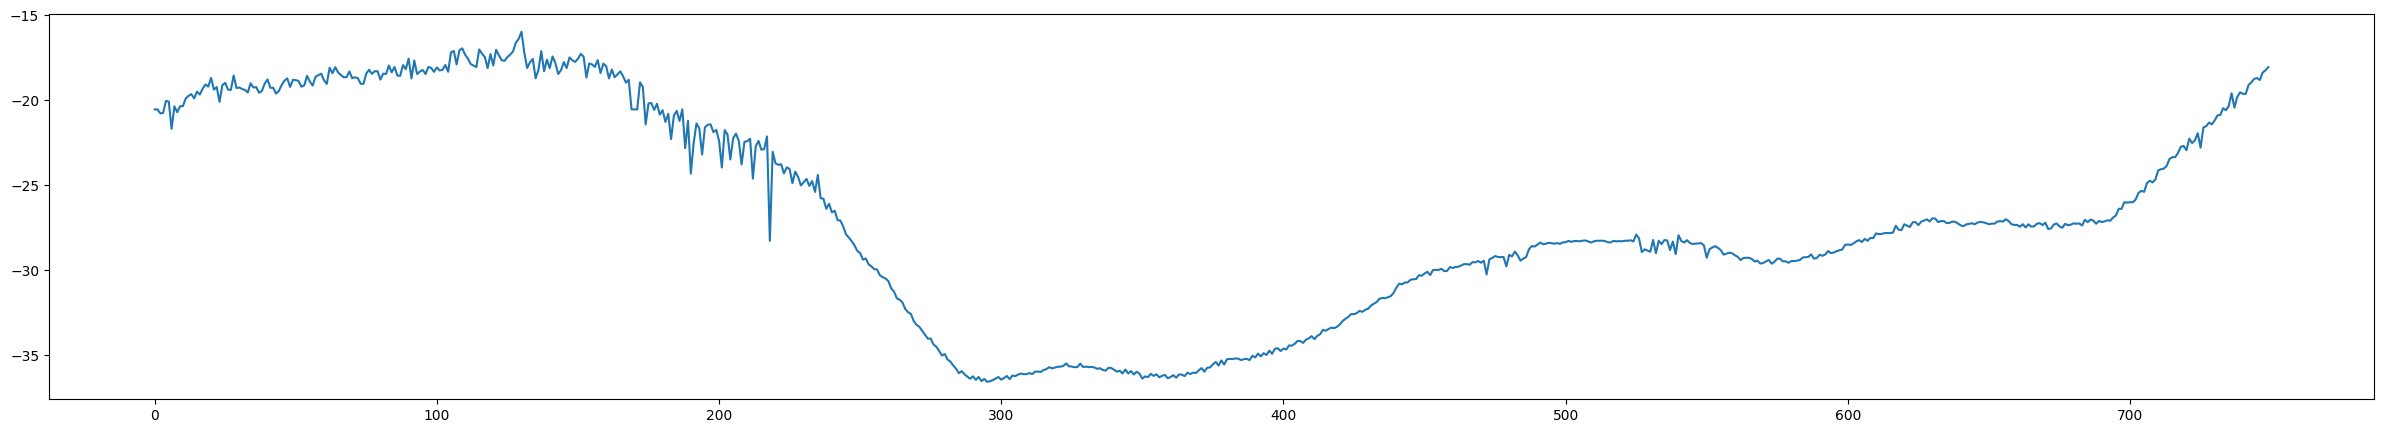

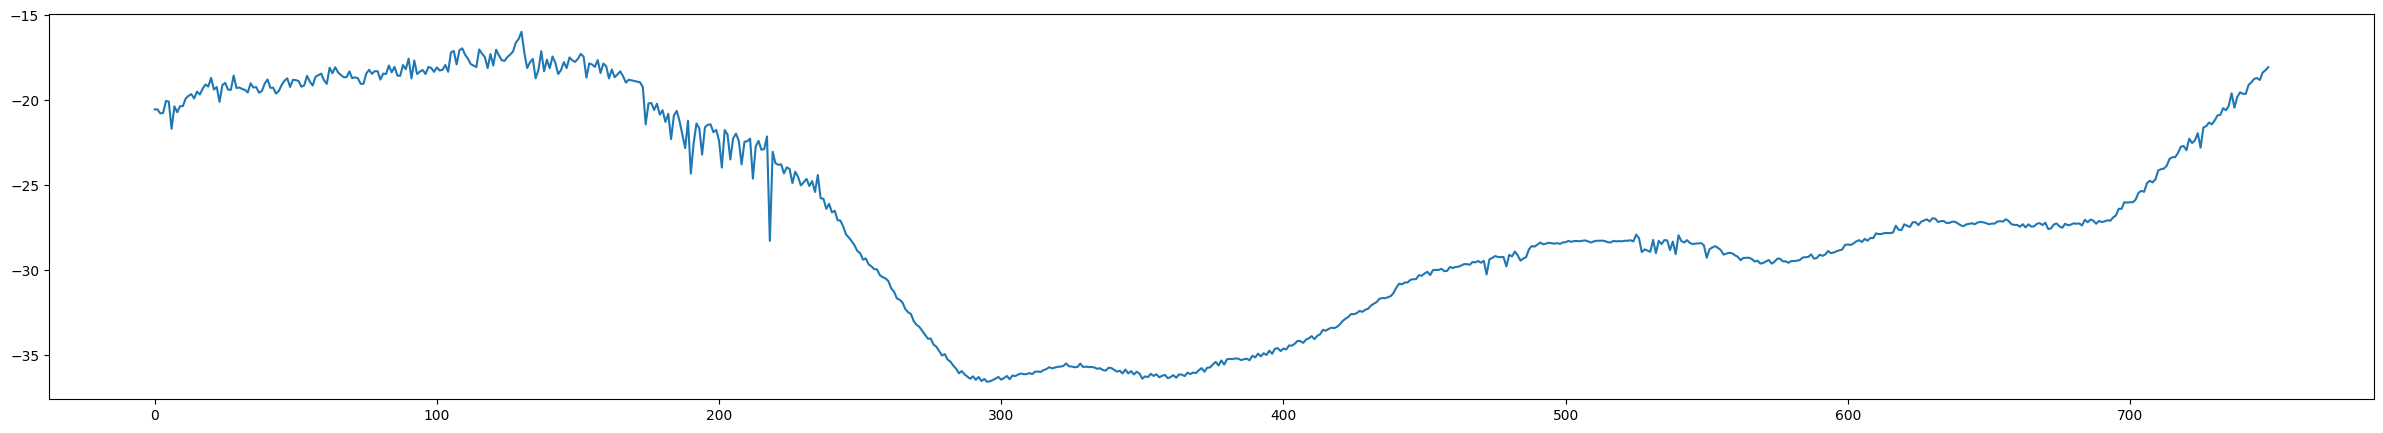

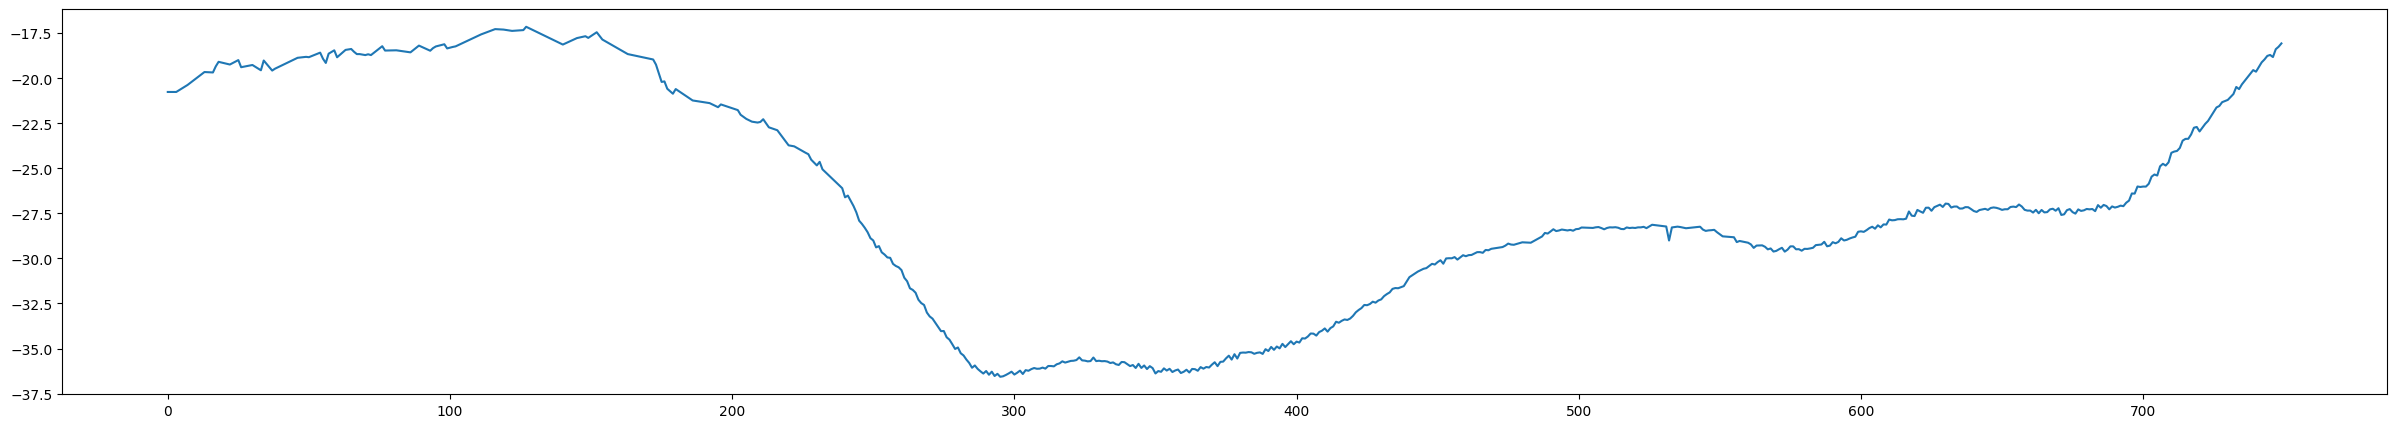

In [3]:
with open("work_dir/cam_params.json", "r") as f:
    camParamsPerImage = json.load(f)
print(len(camParamsPerImage))
cam = Camera()
paramToShow = "pan_degrees"
camParamsPerImage = np.array(camParamsPerImage)
camParamsPerImage, isErroneousParams, ErroneousParamsPos = to_valid_cam_params(
    camParamsPerImage
)
camParamsPerType = camParamsPerImage_to_camParamsPerType(camParamsPerImage)
print("camParamsPerType keys: ", camParamsPerType.keys())
plt.figure(figsize=(30, 5))
plt.plot(camParamsPerType[paramToShow])
# plt.scatter(ErroneousParamsPos, camParamsPerType[paramToShow][ErroneousParamsPos], color="red")
# plt.ylim(-40, 20)
camParamsPerType = linear_interpolation(
    camParamsPerType, isErroneousParams, ErroneousParamsPos
)
plt.figure(figsize=(30, 5))
plt.plot(camParamsPerType[paramToShow])
# plt.scatter(ErroneousParamsPos, camParamsPerType[paramToShow][ErroneousParamsPos], color="red")
# plt.ylim(-40, 20)
camParamsPerType = outliers_remover(
    camParamsPerType,
    isErroneousParams,
    ErroneousParamsPos,
)
plt.figure(figsize=(30, 5))
plt.plot(camParamsPerType[paramToShow])
# plt.scatter(ErroneousParamsPos, camParamsPerType[paramToShow][ErroneousParamsPos], color="red")
# plt.ylim(-40, 20)
basicCamParamsPerType = deepcopy(camParamsPerType)
camParamsPerType = camParamsSmoothing(camParamsPerType)
camParamsPerImage = camParamsPerType_to_camParamsPerImage(camParamsPerType)

In [4]:
basicCamParamsPerType = deepcopy(camParamsPerType)
camParamsPerType = camParamsSmoothing(camParamsPerType)
camParamsPerImage = camParamsPerType_to_camParamsPerImage(camParamsPerType)

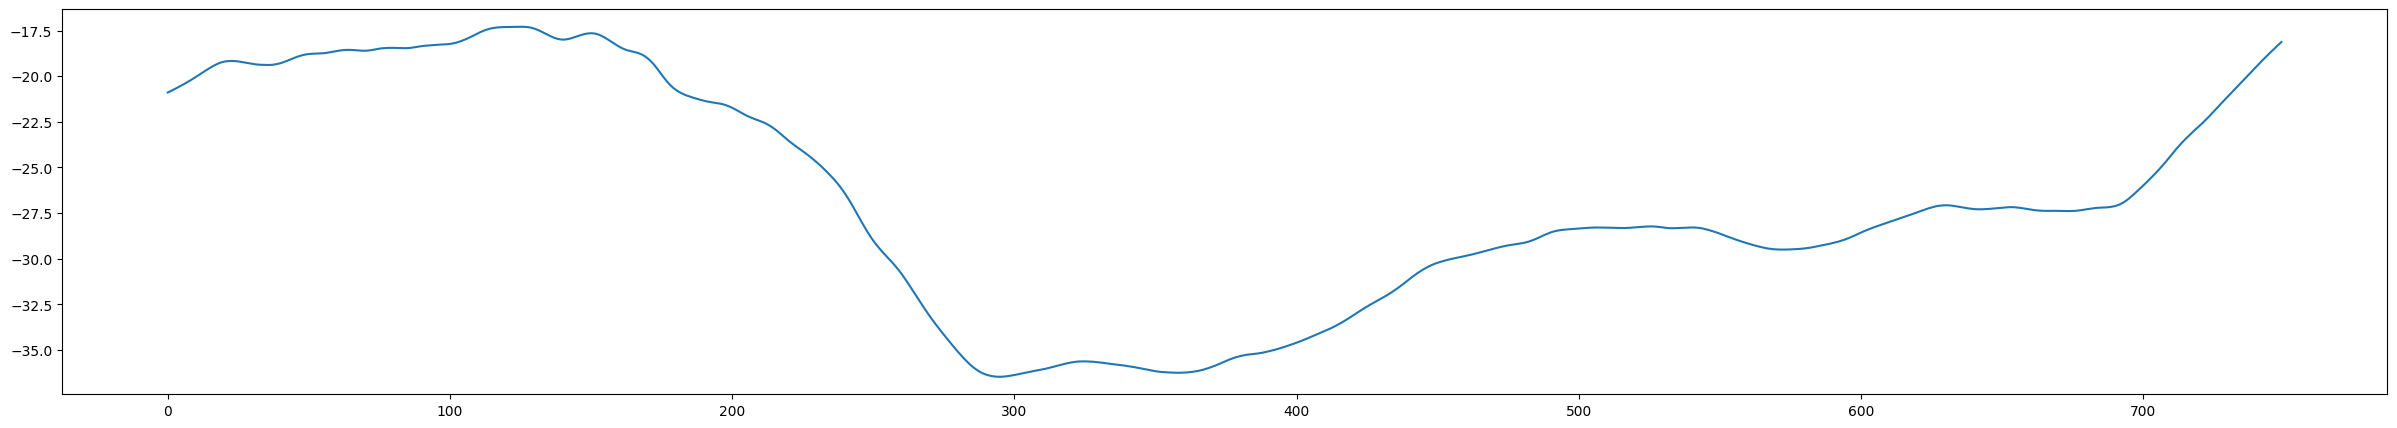

In [5]:
plt.figure(figsize=(30, 5))
plt.plot(camParamsPerType[paramToShow])

Apply semantic segmentation filter on masks to keep biggest blob.

In [7]:
# masksFileNames = os.listdir(maskPath)
# for maskFileName in tqdm(masksFileNames):
#     filteredMask = keep_biggest_blob(os.path.join(maskPath, maskFileName))
#     cv2.imwrite(os.path.join(maskPath, maskFileName), filteredMask)

Compute the parameters of the banner model

In [6]:
bannersObjPts, bannerHeight = compute_banner_model_params(camParamsPerImage, maskPath, imgWidth, imgHeight, nWorkers, nFrames)

Computing banner model parameters: 100%|██████████| 750/750 [00:08<00:00, 85.18it/s]


In [7]:
for side in ["left", "middle", "right"]:
    print(f"Banner {side} objPts:")
    print(bannersObjPts[side])

Banner left objPts:
[[-58.30051345  41.72986377   0.        ]
 [-58.30051345  41.72986377  -1.00001127]
 [-58.30051345 -41.72986377  -1.00001127]
 [-58.30051345 -41.72986377   0.        ]]
Banner middle objPts:
[[-58.30051345 -41.72986377   0.        ]
 [-58.30051345 -41.72986377  -1.00001127]
 [ 60.         -41.72986377  -1.00001127]
 [ 60.         -41.72986377   0.        ]]
Banner right objPts:
[[ 60.         -41.72986377   0.        ]
 [ 60.         -41.72986377  -1.00001127]
 [ 60.          41.72986377  -1.00001127]
 [ 60.          41.72986377   0.        ]]


In [9]:
composite_logo_into_video(
    "/home/vgaspar/Documents/TFE/banner-replacement/FRS-FNRS_rose_transp_resized.png",
    imgPath,
    maskPath,
    camParamsPerImage,
    imgWidth,
    imgHeight,
    8,
    nFrames,
    25,
    1.75,
    bannersObjPts,
    bannerHeight,
    "200.mp4",
)

Saving video: 100%|██████████| 750/750 [00:25<00:00, 29.02it/s]


(80, 152, 3)


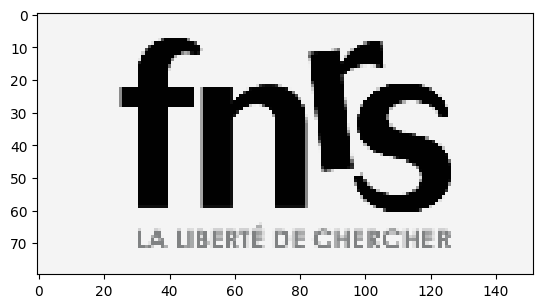

In [37]:
logo = cv2.imread("./video/FRS_FNRS_BLACK_transp.png")
# logo = cv2.imread('FRS-FNRS_rose_transp.png')
logo = cv2.copyMakeBorder(logo, 0, 0, logo.shape[1]//4, logo.shape[1]//4, cv2.BORDER_CONSTANT, value=(255, 255, 255))
logo = cv2.copyMakeBorder(logo, logo.shape[0]//8, logo.shape[0]//8, 0, 0, cv2.BORDER_CONSTANT, value=(255, 255, 255))
scale = 1525.0 / logo.shape[1]
logo = cv2.resize(logo, (0, 0), fx=scale, fy=scale)
# logo[logo == 0] = 1
plt.imshow(cv2.cvtColor(logo, cv2.COLOR_BGR2RGB))
# cv2.imwrite("logo.png", logo)
hsv_logo = cv2.cvtColor(logo, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv_logo)
meanAdVal = np.mean(v) * 0.96 # type: ignore
meanAdSat = np.mean(s) * 0.80 # type: ignore
s = meanAdSat * s / np.mean(s) # type: ignore
v = meanAdVal * v / np.mean(v) # type: ignore
s = np.clip(s, 0, 255).astype(np.uint8)
v = np.clip(v, 0, 255).astype(np.uint8)
hsv_logo = cv2.merge([h, s, v])
logo = cv2.cvtColor(hsv_logo, cv2.COLOR_HSV2BGR)
# Pixels with colour [0, 0, 0] are considered the "background" and will be changed to the main logo colour afterwards.
# To avoid changing the logo colour, we change the logo pixels whose value is [0, 0, 0] to [1, 1, 1]
logo[np.where((logo == [0, 0, 0]).all(axis=2))] = [1, 1, 1]
plt.imshow(cv2.cvtColor(logo, cv2.COLOR_BGR2RGB))
logo = cv2.resize(logo, (0, 0), fx=0.1, fy=0.1)
print(logo.shape)
plt.imshow(cv2.cvtColor(logo, cv2.COLOR_BGR2RGB))

In [38]:
logoWidthInMeters = bannerHeight * (logo.shape[1] / logo.shape[0])
logoWidthInMeters

1.829217926857158

In [39]:
speed = 1.75  # m/s
fps = 25
# compute speed in pixels per frame
speed = speed * logo.shape[1] / fps / logoWidthInMeters
speed

5.8166934862053035

In [40]:
sides = ['left', 'middle', 'right']

In [41]:
bannersObjPts["middle"][2, 0], bannersObjPts["middle"][0, 0]

(57.11912855319369, -56.994569470201185)

In [44]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def compositing_worker(i):
    sides = ['left', 'middle', 'right']
    # print(i)
    logoBanners = dict()
    cut = int(round(i * speed)) % logo.shape[1]
    for side in sides:
        if side == 'middle':
            logoBannerLen = bannersObjPts['middle'][2, 0] - bannersObjPts['middle'][0, 0]
        else:
            logoBannerLen = -2 * bannersObjPts['middle'][0, 1]
        bannerBeginning = cut
        logoBannerLen -= ((logo.shape[1] - bannerBeginning) / logo.shape[1]) * logoWidthInMeters
        nLogosInBanner = np.floor(logoBannerLen / logoWidthInMeters).astype(np.int32)
        rest = logoBannerLen / logoWidthInMeters - nLogosInBanner
        cut = np.round(rest * logo.shape[1]).astype(np.int32)
        banner = np.concatenate([logo[:, bannerBeginning:]] + [logo for _ in range(nLogosInBanner)] + [logo[:, :cut]], axis=1)
        # if banner.shape[1] >= 32766:
        #     # Resize to a width of 32766 pixels, keep the aspect ratio
        banner = cv2.resize(banner, (32766, int(32766 * (banner.shape[0] / banner.shape[1]))))
        logoBanners[side] = banner
        
    img = cv2.imread(imgPath + str(i).zfill(6) + '.png')
    cam.from_json_parameters(camParamsPerImage[i])
    mask = cv2.imread(maskPath + "filtered_" + str(i).zfill(6) + ".png", cv2.IMREAD_GRAYSCALE)
    projectedBanners = np.zeros_like(img)
    for side in sides:
        imgPts = np.array([cam.project_point(p, distort=False)[:2] for p in bannersObjPts[side]])
        imgPts[1][0] = imgPts[0][0]
        imgPts[2][0] = imgPts[3][0]
        if np.any(np.all(imgPts == 0, axis=1) == True) or (imgPts[0][0] < 0 and imgPts[3][0] < 0) or (imgPts[0][0] >= img.shape[1] and imgPts[3][0] >= img.shape[1]):   # banner is not in the image
            continue

        tmpHeight, tmpWidth = logoBanners[side].shape[:2]
        dstPts = np.array(imgPts, dtype=np.float32)

        increase = 50  # ! Maybe try with smg like int(tmpHeight * 0.12)
        srcPts = np.array([[0, tmpHeight-1+increase], [0, increase], [tmpWidth-1, increase], [tmpWidth-1, tmpHeight-1+increase]], dtype=np.float32)
        Minverse = cv2.getPerspectiveTransform(dstPts, srcPts)
        M = cv2.getPerspectiveTransform(srcPts, dstPts)


        warpedMask = cv2.warpPerspective(mask, Minverse, (tmpWidth, tmpHeight + 2*increase))
        binWarpedMask = warpedMask > 0 # type: ignore
        y, x = np.where(binWarpedMask)
        if len(y) == 0 or len(x) == 0:
            continue
        poly = PolynomialFeatures(degree=2, include_bias=True)
        X = poly.fit_transform(x.reshape(-1, 1))
        reg = LinearRegression().fit(X, y)
        Y = reg.predict(X)
        width = np.mean(abs(y - Y)) * 4
        
        x = np.arange(32766, step=762) # type: ignore
        xRegression = np.arange(32766)
        xPoly = poly.fit_transform(xRegression.reshape(-1, 1))
        yc = reg.predict(xPoly)
        yt = yc - width/2
        yb = yc + width/2
        topLinePts = np.float32([[x_, y_] for x_, y_ in zip(xRegression, yt)]).reshape(-1, 1, 2) # type: ignore
        bottomLinePts = np.float32([[x_, y_] for x_, y_ in zip(xRegression, yb)]).reshape(-1, 1, 2) # type: ignore
        topLinePts = cv2.perspectiveTransform(topLinePts, M).reshape(-1, 2)
        bottomLinePts = cv2.perspectiveTransform(bottomLinePts, M).reshape(-1, 2)
        srcPts2 = np.float32([[0, 0], [761, 0], [761, logoBanners[side].shape[0]-1], [0, logoBanners[side].shape[0]-1]]) # type: ignore

        for x_ in x:
            billPts = np.float32([topLinePts[x_], topLinePts[x_+761], bottomLinePts[x_+761], bottomLinePts[x_]]) # type: ignore
            M2 = cv2.getPerspectiveTransform(srcPts2, billPts) # type: ignore
            warpedLogo = cv2.warpPerspective(logoBanners[side][:, x_:x_+762], M2, (img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST)  # flags=cv2.INTER_LINEAR might be better ?
            projectedBanners = cv2.bitwise_or(projectedBanners, warpedLogo)


    binMask = np.bitwise_and(mask > 0, mask < 3) # type: ignore

    #! Set background of tmp to white
    # ? but here it is black, might set it to main colour of image
    projectedBanners[np.where((projectedBanners == [0, 0, 0]).all(axis=2))] = logo[0,0]
    img[binMask] = projectedBanners[binMask]
    img2 = deepcopy(img)
    img2[binMask] = cv2.GaussianBlur(img, (3, 3), 0)[binMask]
    alpha = 0.3
    img3 = cv2.addWeighted(img, alpha, img2, 1.0 - alpha, 0)
    # save image in "output" folder
    cv2.imwrite("output/" + str(i).zfill(6) + ".png", img3)
    
    
    # cv2.imshow('image', img3)
    # cv2.waitKey(1)
    # print(img3.dtype)
    # return img3
    # return 0

In [43]:
compositing_worker(0)

(80, 6451, 3)
(406, 32766, 3)
(80, 9482, 3)
(276, 32766, 3)
(80, 6451, 3)
(406, 32766, 3)


In [45]:
from multiprocessing import Pool

nFrames = 50
# print(range(nFrames))

if not os.path.exists("output"):
    os.makedirs("output")

with Pool(14) as p:
    # imgs = p.map(compositing_worker, range(nFrames))
    imgs = list(tqdm(p.imap_unordered(compositing_worker, range(nFrames)), total=nFrames))
    # res = tqdm(p.imap(compositing_worker, range(nFrames)), total=nFrames)
# print(imgs[0].shape)
# print(len(imgs))

100%|██████████| 50/50 [00:14<00:00,  3.50it/s]


In [46]:
# from multiprocessing import Pool

# nFrames = 100

# with Pool(nWorkers) as p:
#     imgs = tqdm(p.imap(compositing_worker, range(nFrames)), total=nFrames)

# print("Saving video...")
# out = cv2.VideoWriter('video/out360/tta_composite.avi', cv2.VideoWriter_fourcc(*'DIVX'), fps, (imgWidth, imgHeight))
# for img in tqdm(imgs):
#     out.write(img)
# out.release()

# save video using images in the "output" folder
out = cv2.VideoWriter('tta_composite.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (imgWidth, imgHeight))
for i in tqdm(range(nFrames)):
    img = cv2.imread("output/" + str(i).zfill(6) + ".png")
    out.write(img)
out.release()

100%|██████████| 50/50 [00:01<00:00, 28.12it/s]
